# Time-series Analysis

Table of Contents
- a) Understanding Data:
  1. Hypothesis Generation
  2. Getting the system ready and loading the data
  3. Dataset Structure and Content
  4. Feature Extraction
  5. Exploratory Analysis
- b) Forecasting using Multiple Modeling Techniques:
   1. Splitting the data into training and validation part
   2. Modeling techniques
   3. Holt’s Linear Trend Model on daily time series
   4. Holt Winter’s Model on daily time series
   5. Introduction to ARIMA model
   6. Parameter tuning for ARIMA model
   7. SARIMAX model on daily time series

## 1) Hypothesis Generation

Hypothesis generation helps us to point out the factors which might affect our dependent variable. Below are some of the hypotheses which I think can affect the passenger count(dependent variable for this time series problem) on the JetRail:

   1. There will be an increase in the traffic as the years pass by.

    Explanation - Population has a general upward trend with time, so I can expect more people to travel by JetRail. Also, generally companies expand their businesses over time leading to more customers travelling through JetRail.

   2. The traffic will be high from May to October.

    Explanation - Tourist visits generally increases during this time perion.

   3. Traffic on weekdays will be more as compared to weekends/holidays.

    Explanation - People will go to office on weekdays and hence the traffic will be more

   4. Traffic during the peak hours will be high.

    Explanation - People will travel to work, college.

We will try to validate each of these hypothesis based on the dataset. Now let’s have a look at the dataset.

## 2) Getting the system ready and loading the data

In [1]:
import pandas as pd          
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime    # To access datetime 
from pandas import Series        # To work on series 
%matplotlib inline 
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv("Train_SU63ISt.csv") 
test=pd.read_csv("Test_0qrQsBZ.csv")

In [3]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


Let’s make a copy of train and test data so that even if we do changes in these dataset we do not lose the original dataset.

In [4]:
train_original=train.copy() 
test_original=test.copy()

## 3) Dataset Structure and Content

In [5]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [6]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

In [7]:
train.shape, test.shape

((18288, 3), (5112, 2))

## 4) Feature Extraction

we have to change the data type to datetime format otherwise we can not extract features from it.

In [8]:
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M') 
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

In [9]:
train.head()

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


let’s extract the year, month, day and hour from the Datetime to validate our hypothesis.

In [10]:
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

We made a hypothesis for the traffic pattern on weekday and weekend as well. So, let’s make a weekend variable to visualize the impact of weekend on traffic.
   - We will first extract the day of week from Datetime and then based on the values we will assign whether the day is a weekend or not.
   - Values of 5 and 6 represents that the days are weekend.

In [11]:
train['day of week']=train['Datetime'].dt.dayofweek 
temp = train['Datetime']

Let’s assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.

In [12]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = train['Datetime'].apply(applyer) 
train['weekend']=temp2

In [13]:
train.head()

,ID,Datetime,Count,year,month,day,Hour,day of week,weekend
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1


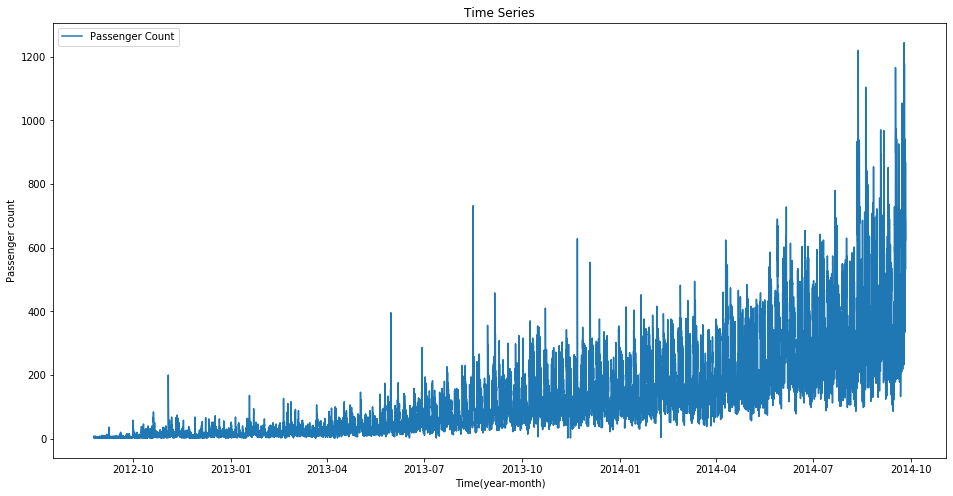

In [15]:
train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis. 
df=train.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis. 
ts = df['Count'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')

Here we can infer that there is an increasing trend in the series, i.e., the number of count is increasing with respect to time. We can also see that at certain points there is a sudden increase in the number of counts. The possible reason behind this could be that on particular day, due to some event the traffic was high.

## 5) Exploratory Analysis

Let us try to verify our hypothesis using the actual data.
Our first hypothesis was traffic will increase as the years pass by. So let’s look at yearly passenger count.

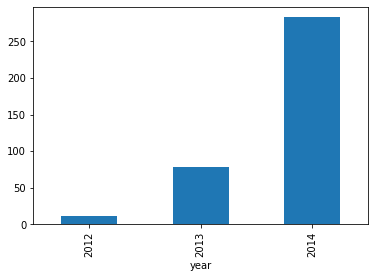

In [16]:
train.groupby('year')['Count'].mean().plot.bar()

We see an exponential growth in the traffic with respect to year which validates our hypothesis.
Our second hypothesis was about increase in traffic from May to October. So, let’s see the relation between count and month.

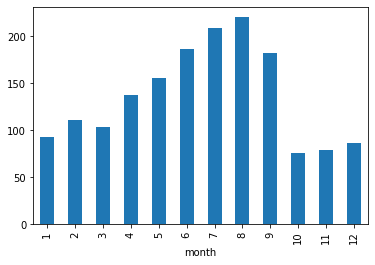

In [17]:
train.groupby('month')['Count'].mean().plot.bar()

Here we see a decrease in the mean of passenger count in last three months. This does not look right. Let’s look at the monthly mean of each year separately.

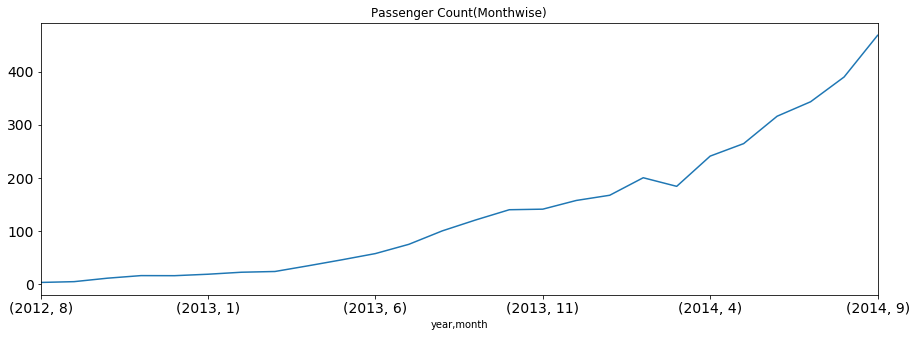

In [18]:
temp=train.groupby(['year', 'month'])['Count'].mean() 
temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14)

   - We see that the months 10, 11 and 12 are not present for the year 2014 and the mean value for these months in year 2012 is very less.
   - Since there is an increasing trend in our time series, the mean value for rest of the months will be more because of their larger passenger counts in year 2014 and we will get smaller value for these 3 months.
   - In the above line plot we can see an increasing trend in monthly passenger count and the growth is approximately exponential.

Let’s look at the daily mean of passenger count.

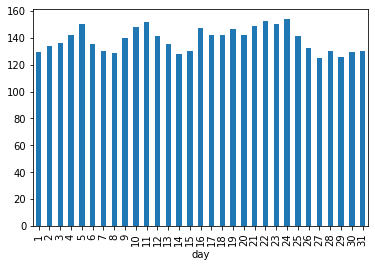

In [19]:
train.groupby('day')['Count'].mean().plot.bar()

We are not getting much insights from day wise count of the passengers.
We also made a hypothesis that the traffic will be more during peak hours. So let’s see the mean of hourly passenger count.

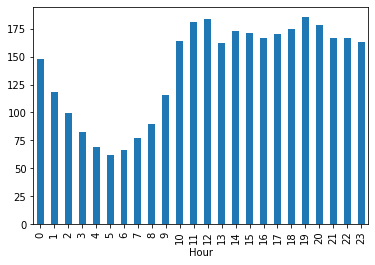

In [20]:
train.groupby('Hour')['Count'].mean().plot.bar()

   - It can be inferred that the peak traffic is at 7 PM and then we see a decreasing trend till 5 AM.
   - After that the passenger count starts increasing again and peaks again between 11AM and 12 Noon.

Let’s try to validate our hypothesis in which we assumed that the traffic will be more on weekdays.

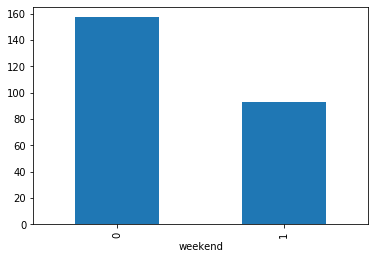

In [21]:
train.groupby('weekend')['Count'].mean().plot.bar()

It can be inferred from the above plot that the traffic is more on weekdays as compared to weekends which validates our hypothesis.
Now we will try to look at the day wise passenger count.

Note - 0 is the starting of the week, i.e., 0 is Monday and 6 is Sunday.

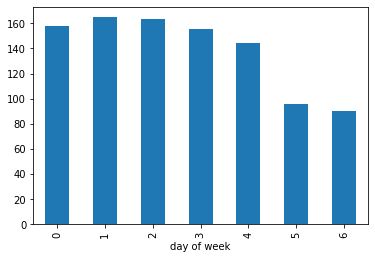

In [22]:
train.groupby('day of week')['Count'].mean().plot.bar()

From the above bar plot, we can infer that the passenger count is less for saturday and sunday as compared to the other days of the week. Now we will look at basic modeling techniques. Before that we will drop the ID variable as it has nothing to do with the passenger count.

In [23]:
train.head()

,ID,Datetime,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,,
2012-08-25 00:00:00,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1


In [24]:
train=train.drop('ID',1)

As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

In [25]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
# Hourly time series 
hourly = train.resample('H').mean() 
# Converting to daily mean 
daily = train.resample('D').mean() 
# Converting to weekly mean 
weekly = train.resample('W').mean() 
# Converting to monthly mean 
monthly = train.resample('M').mean()

/home/ambir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


Let’s look at the hourly, daily, weekly and monthly time series.

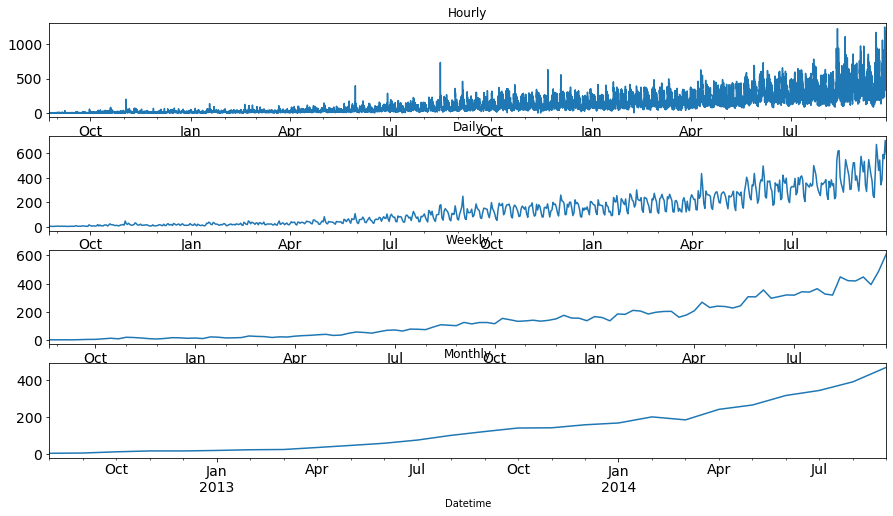

In [26]:
fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

plt.show()

We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

In [27]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp  

# Converting to daily mean 
test = test.resample('D').mean() 

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
# Converting to daily mean 
train = train.resample('D').mean()

/home/ambir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [28]:
train.head()

,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


## Splitting the data into training and validation part

- NOTE - It is always a good practice to create a validation set that can be used to assess our models locally. If the validation metric(rmse) is changing in proportion to public leaderboard score, this would imply that we have chosen a stable validation technique.

To divide the data into training and validation set, we will take last 3 months as the validation data and rest for training data. We will take only 3 months as the trend will be the most in them. If we take more than 3 months for the validation set, our training set will have less data points as the total duration is of 25 months. So, it will be a good choice to take 3 months for validation set.

The starting date of the dataset is 25-08-2012 as we have seen in the exploration part and the end date is 25-09-2014.

In [29]:
Train=train.ix['2012-08-25':'2014-06-24'] 
valid=train.ix['2014-06-25':'2014-09-25']

/home/ambir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/home/ambir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


Now we will look at how the train and validation part has been divided.

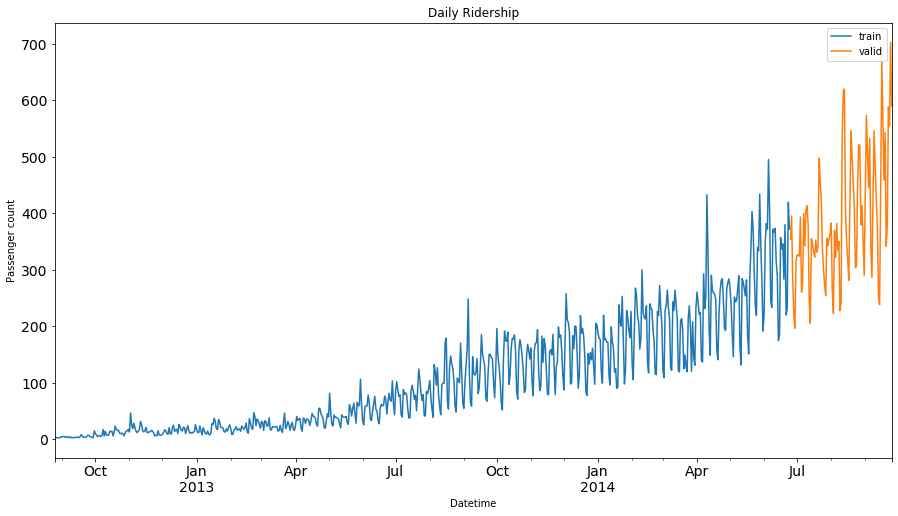

In [30]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

## Modeling Techniques


We will look at various models now to forecast the time series . Methods which we will be discussing for the forecasting are:
 - i) Naive Approach
 - ii) Moving Average
 - iii) Simple Exponential Smoothing
 - iv) Holt’s Linear Trend Model

### i) Naive Approach

In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we can expect a straight horizontal line as the prediction. Lets understand it with an example and an image:

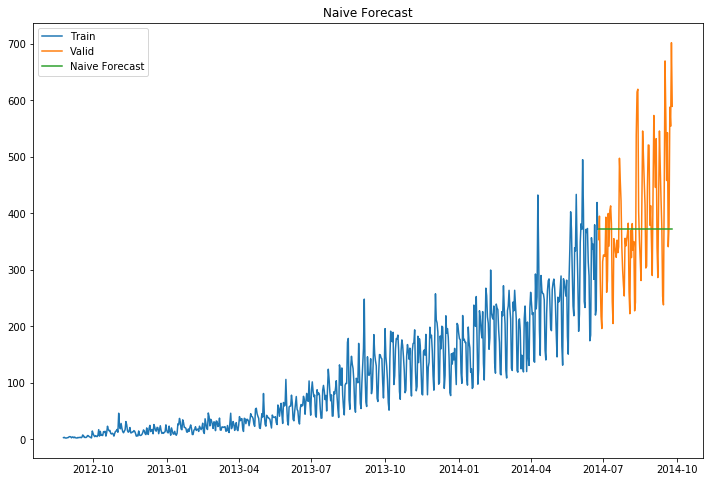

In [31]:
dd= np.asarray(Train.Count) 
y_hat = valid.copy() 
y_hat['naive'] = dd[len(dd)-1] 
plt.figure(figsize=(12,8)) 
plt.plot(Train.index, Train['Count'], label='Train') 
plt.plot(valid.index,valid['Count'], label='Valid') 
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()

We will now calculate RMSE to check the accuracy of our model on validation data set.

In [32]:
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive)) 
print(rms)

111.79050467496724


### ii) Moving Average

In this technique we will take the average of the passenger counts for last few time periods only.

Lets try the rolling mean for last 10, 20, 50 days and visualize the results.

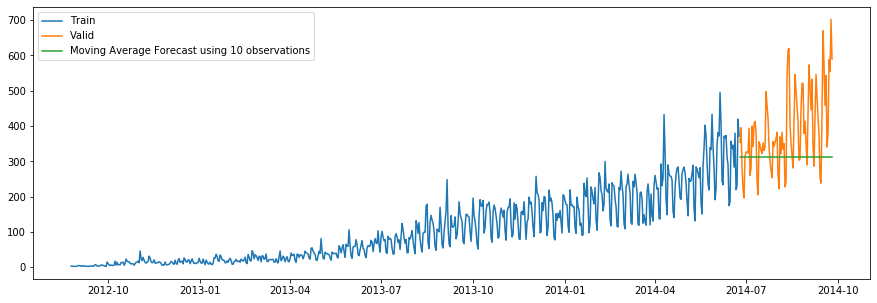

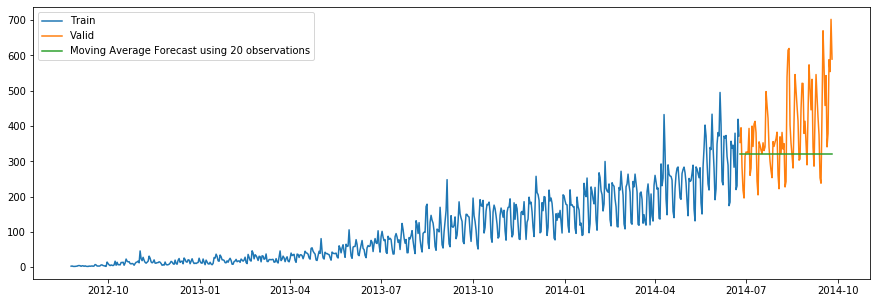

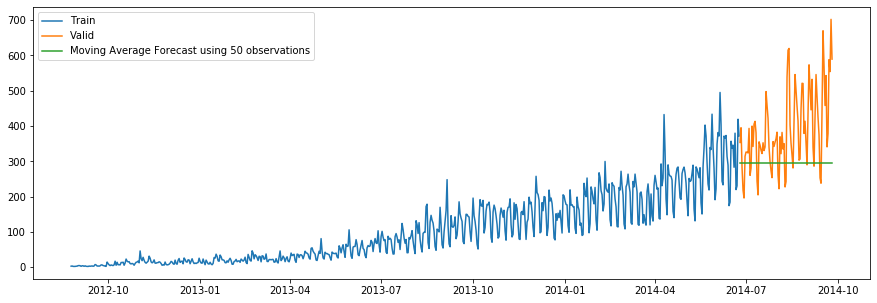

In [33]:
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show() 
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1] # average of last 20 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations') 
plt.legend(loc='best') 
plt.show() 
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations') 
plt.legend(loc='best') 
plt.show()

We took the average of last 10, 20 and 50 observations and predicted based on that. This value can be changed in the above code in .rolling().mean() part. We can see that the predictions are getting weaker as we increase the number of observations.

In [34]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)) 
print(rms)

144.19175679986802


### iii) Simple Exponential Smoothing

   - In this technique, we assign larger weights to more recent observations than to observations from the distant past.
   - The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

Here the predictions are made by assigning larger weight to the recent values and lesser weight to the old values.



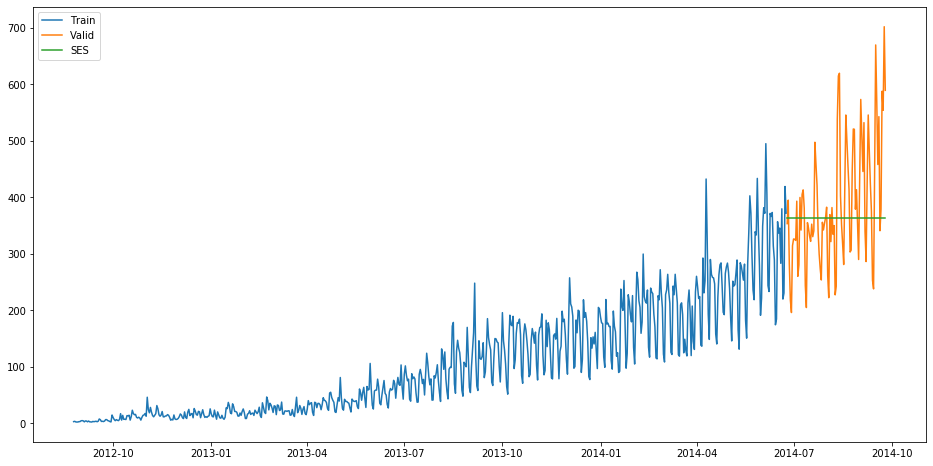

In [35]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 

y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

In [36]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES)) 
print(rms)

113.43708111884514


We can infer that the fit of the model has improved as the rmse value has reduced.

### iv) Holt’s Linear Trend Model

  -  It is an extension of simple exponential smoothing to allow forecasting of data with a trend.
  -  This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.

First of all let us visualize the trend, seasonality and error in the series.

We can decompose the time series in four parts.

-    Observed, which is the original time series.
-    Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.
-    Seasonal, which tells us about the seasonality in the time series.
-    Residual, which is obtained by removing any trend or seasonality in the time series.

Lets visualize all these parts.

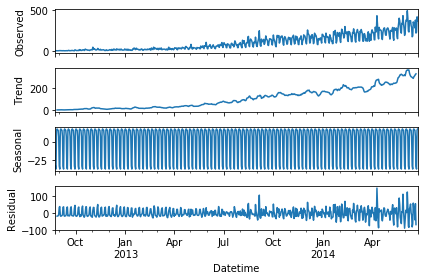

In [37]:
import statsmodels.api as sm 

sm.tsa.seasonal_decompose(Train.Count).plot() 
result = sm.tsa.stattools.adfuller(train.Count) 
plt.show()

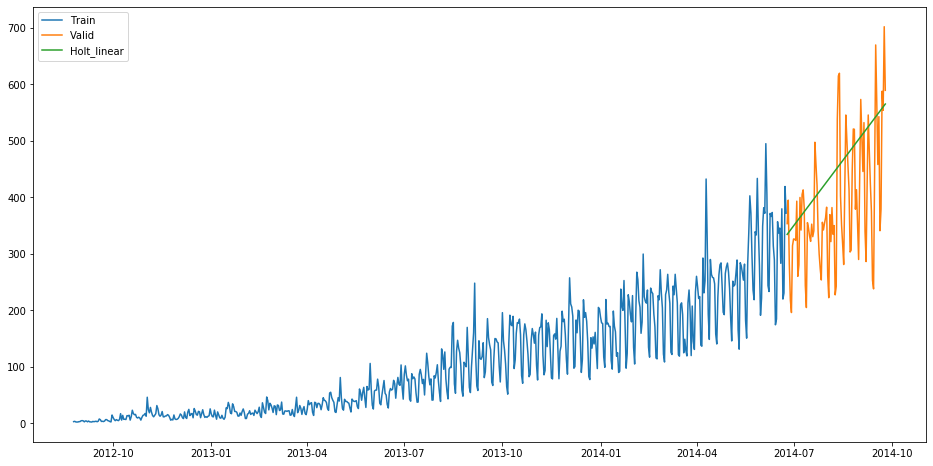

In [38]:
y_hat_avg = valid.copy() 
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

We can see an inclined line here as the model has taken into consideration the trend of the time series.

In [39]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear)) 
print(rms)

112.94278345314041


## 3) Holt’s Linear Trend Model on daily time series

-    Now let’s try to make holt’s linear trend model on the daily time series and make predictions on the test dataset.
-    We will make predictions based on the daily time series and then will distribute that daily prediction to hourly predictions.
-    We have fitted the holt’s linear trend model on the train dataset and validated it using validation dataset.

In [40]:
submission=pd.read_csv("Sample_Submission_QChS6c3.csv")

In [41]:
predict=fit1.forecast(len(test))

In [42]:
test['prediction']=predict

Remember this is the daily predictions. We have to convert these predictions to hourly basis. * To do so we will first calculate the ratio of passenger count for each hour of every day. * Then we will find the average ratio of passenger count for every hour and we will get 24 ratios. * Then to calculate the hourly predictions we will multiply the daily prediction with the hourly ratio.

In [43]:
# Calculating the hourly ratio of count 
train_original['ratio']=train_original['Count']/train_original['Count'].sum() 

In [44]:
# Grouping the hourly ratio 
temp=train_original.groupby(['Hour'])['ratio'].sum() 

In [45]:
# Groupby to csv format 
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('GROUPby.csv')

In [46]:
temp2=pd.read_csv("GROUPby.csv") 
temp2=temp2.drop('Hour.1',1) 

In [47]:
# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1) 

In [48]:
# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='Hour', how='left') 

In [49]:
# Converting the ratio to the original scale 
prediction['Count']=prediction['prediction']*prediction['ratio']*24 
prediction['ID']=prediction['ID_y']

In [50]:
submission=prediction.drop(['ID_x', 'day', 'ID_y','prediction','Hour', 'ratio'],axis=1) 
# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt linear.csv')

## 4) Holt winter’s model on daily time series

-    Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.
-    The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.
-    One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.

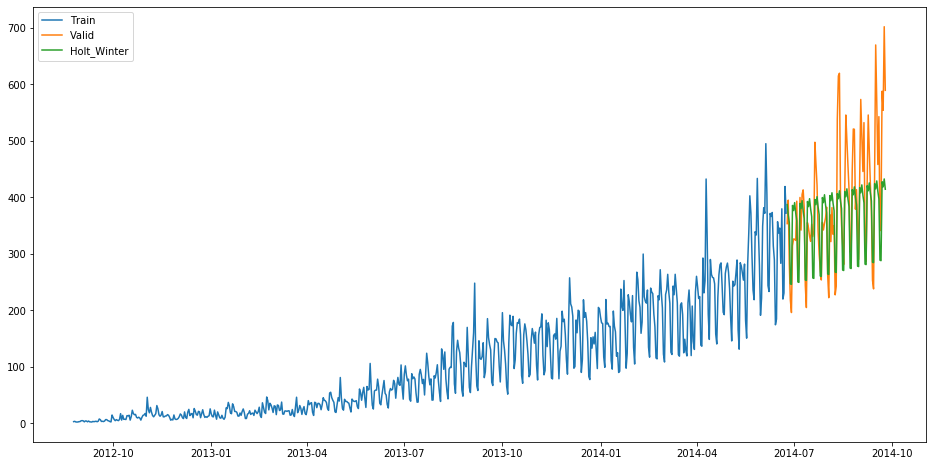

In [51]:
y_hat_avg = valid.copy() 
fit1 = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit() 
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

In [52]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter)) 
print(rms)

82.38011425480599


<br>

## 5) Introduction to ARIMA model

-    ARIMA stands for Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p,d,q).
-    Here p is the order of the autoregressive model(number of time lags)
-    d is the degree of differencing(number of times the data have had past values subtracted)
-    q is the order of moving average model. We will discuss more about these parameters in next section.

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

### What is a stationary time series?

There are three basic criterion for a series to be classified as stationary series :
   - The mean of the time series should not be a function of time. It should be constant.
   - The variance of the time series should not be a function of time.
   - THe covariance of the ith term and the (i+m)th term should not be a function of time.

### Why do we have to make the time series stationary?

We make the series stationary to make the variables independent. Variables can be dependent in various ways, but can only be independent in one way. So, we will get more information when they are independent. Hence the time series must be stationary.

If the time series is not stationary, firstly we have to make it stationary. For doing so, we need to remove the trend and seasonality from the data. 

## 6) Parameter tuning for ARIMA model

First of all we have to make sure that the time series is stationary. If the series is not stationary, we will make it stationary.
### Stationarity Check

-    We use Dickey Fuller test to check the stationarity of the series.
-    The intuition behind this test is that it determines how strongly a time series is defined by a trend.
-    The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
-    The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

We interpret this result using the Test Statistics and critical value. If the Test Statistics is smaller than critical value, it suggests we reject the null hypothesis (stationary), otherwise a greater Test Statistics suggests we accept the null hypothesis (non-stationary).

Let’s make a function which we can use to calculate the results of Dickey-Fuller test.

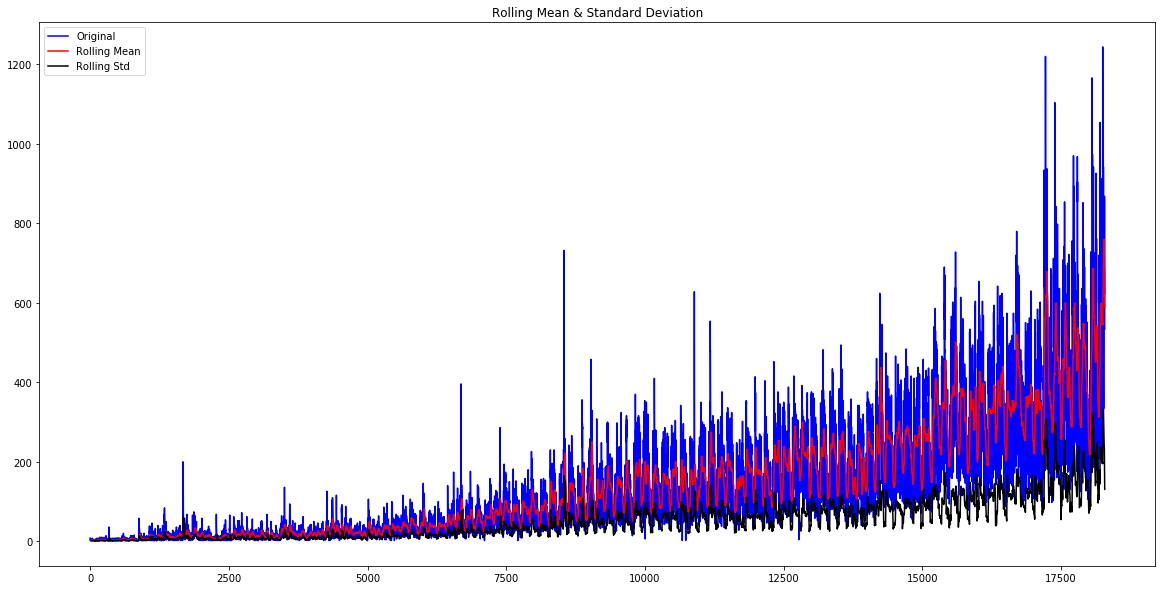

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [53]:
from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries):
        #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=24) # 24 hours on each day
    #rolstd = pd.rolling_std(timeseries, window=24)
    rolmean = pd.Series(timeseries).rolling(window=24).mean()
    rolstd = pd.Series(timeseries).rolling(window=24).std()
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10

test_stationarity(train_original['Count'])

The statistics shows that the time series is stationary as Test Statistic < Critical value but we can see an increasing trend in the data. So, firstly we will try to make the data more stationary. For doing so, we need to remove the trend and seasonality from the data.

### Removing Trend
-    A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.
-    We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example log transformation.
-    We will take rolling average here to remove the trend. We will take the window size of 24 based on the fact that each day has 24 hours.

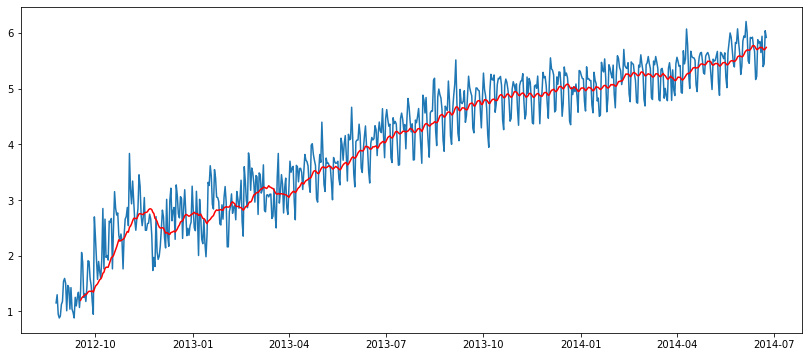

In [54]:
Train_log = np.log(Train['Count']) 
valid_log = np.log(valid['Count'])

#moving_avg = pd.rolling_mean(Train_log, 24) 
moving_avg = pd.Series(Train_log).rolling(window=24).mean()
plt.figure(figsize=(14,6)) 

plt.plot(Train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

So we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.

In [55]:
train_log_moving_avg_diff = Train_log - moving_avg

Since we took the average of 24 values, rolling mean is not defined for the first 23 values. So let’s drop those null values.

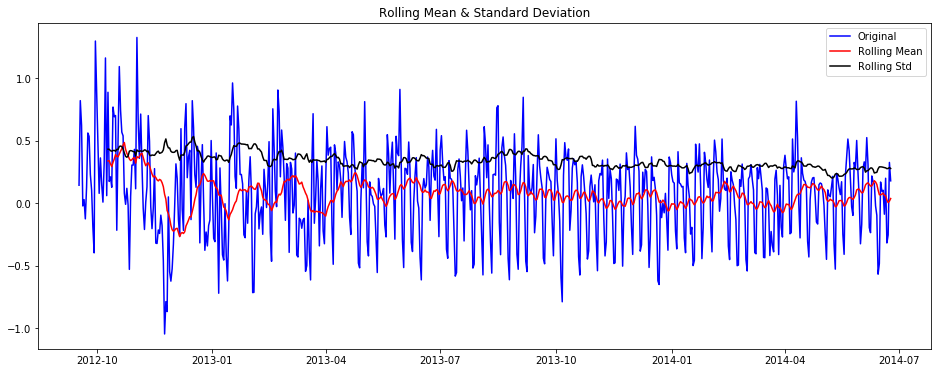

Results of Dickey-Fuller Test:
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [56]:
plt.figure(figsize=(16,6)) 

train_log_moving_avg_diff.dropna(inplace = True) 
test_stationarity(train_log_moving_avg_diff)

We can see that the Test Statistic is very smaller as compared to the Critical Value. So, we can be confident that the trend is almost removed.

Let’s now stabilize the mean of the time series which is also a requirement for a stationary time series.
-    Differencing can help to make the series stable and eliminate the trend.

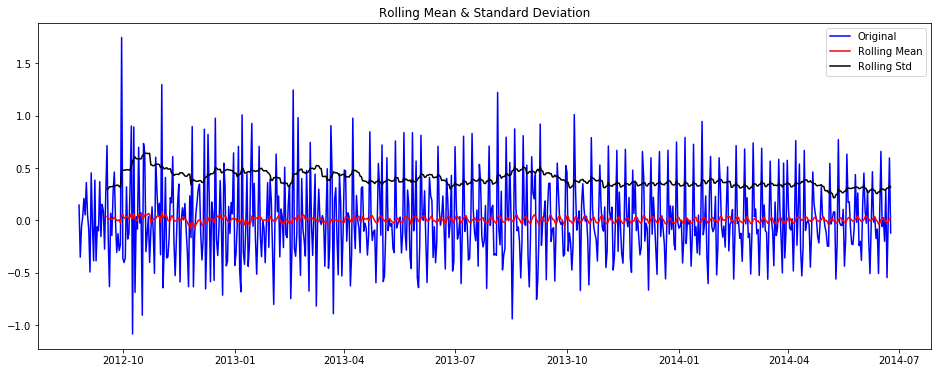

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [57]:
plt.figure(figsize=(16,6)) 

train_log_diff = Train_log - Train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

Now we will decompose the time series into trend and seasonality and will get the residual which is the random variation in the series.

### Removing Seasonality
-    By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).
-    Seasonality is always of a fixed and known period.
-    We will use seasonal decompose to decompose the time series into trend, seasonality and residuals.

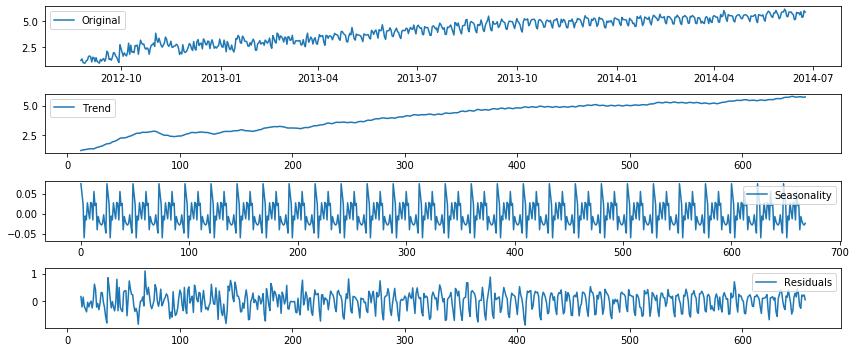

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.figure(figsize=(12,5)) 
plt.subplot(411) 
plt.plot(Train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

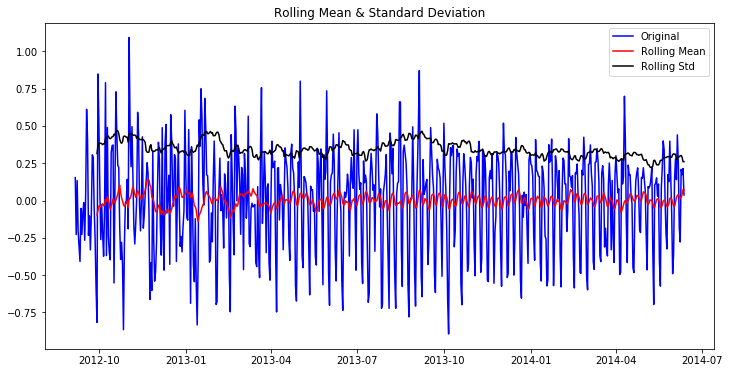

Results of Dickey-Fuller Test:
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [59]:
plt.figure(figsize=(12,6)) 
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = Train_log.index 
train_log_decompose.set_index('date', inplace = True) 
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])

-    It can be interpreted from the results that the residuals are stationary.
-    Now we will forecast the time series using different models.

### Forecasting the time series using ARIMA

-    First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the p,d,q parameters.
-    To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.
-    ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.
-    PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [60]:
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

/home/ambir/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


### ACF and PACF plot

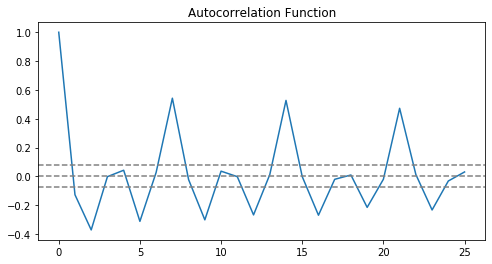

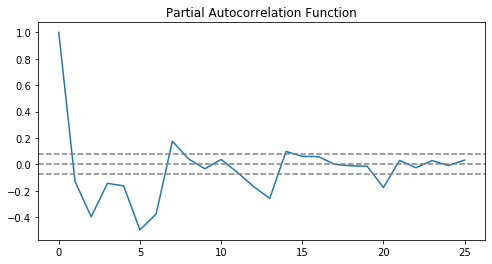

In [61]:
plt.figure(figsize=(8,4)) 

plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 

plt.figure(figsize=(8,4)) 
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

-    p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=1.
-    q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=1.
-    Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA model separately and then combine them together.

### AR model
The autoregressive model specifies that the output variable depends linearly on its own previous values.

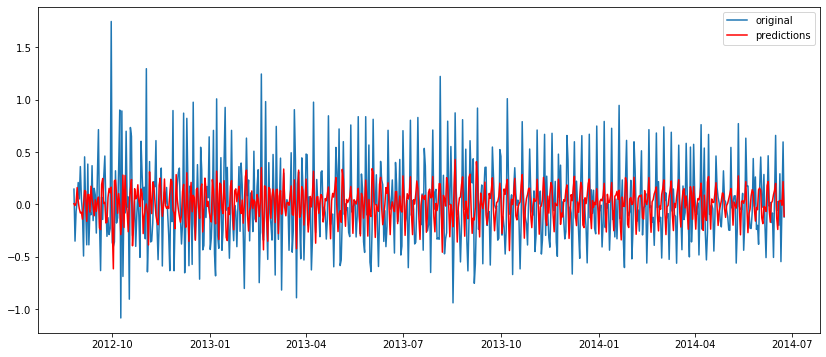

In [62]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1)  
plt.figure(figsize=(14,6)) 
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show()

Lets plot the validation curve for AR model.
We have to change the scale of the model to the original scale.
First step would be to store the predicted results as a separate series and observe it.

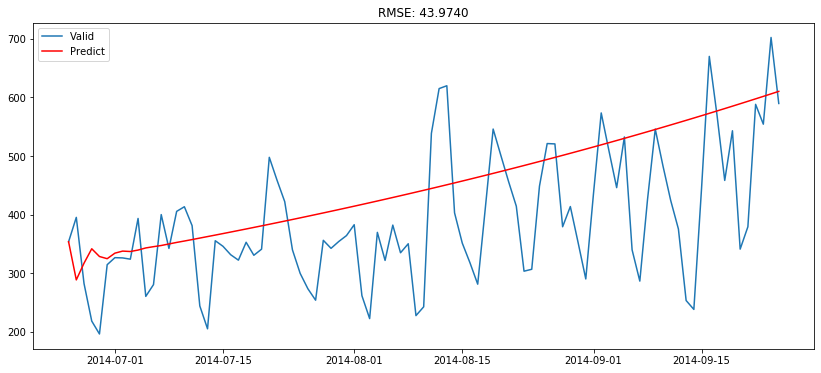

In [63]:
AR_predict=results_AR.predict(start="2014-06-25", end="2014-09-25") 
AR_predict=AR_predict.cumsum().shift().fillna(0) 
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
AR_predict1=AR_predict1.add(AR_predict,fill_value=0) 
AR_predict = np.exp(AR_predict1)

plt.figure(figsize=(14,6)) 
plt.plot(valid['Count'], label = "Valid") 
plt.plot(AR_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0])) 
plt.show()

Here the red line shows the prediction for the validation set. Let’s build the MA model now.

### MA model
The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

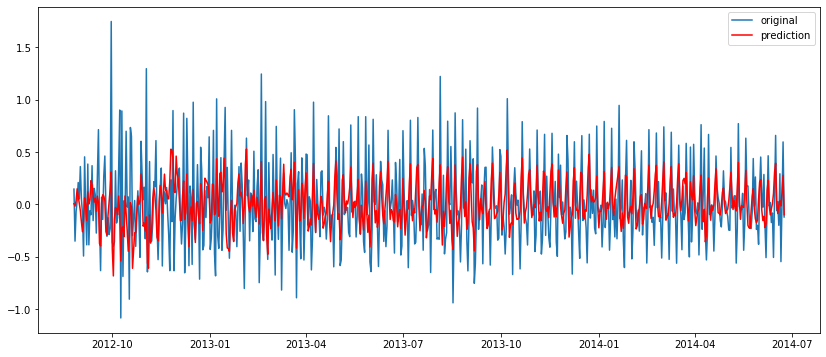

In [64]:
model = ARIMA(Train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model 
results_MA = model.fit(disp=-1)  
plt.figure(figsize=(14,6)) 
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show()

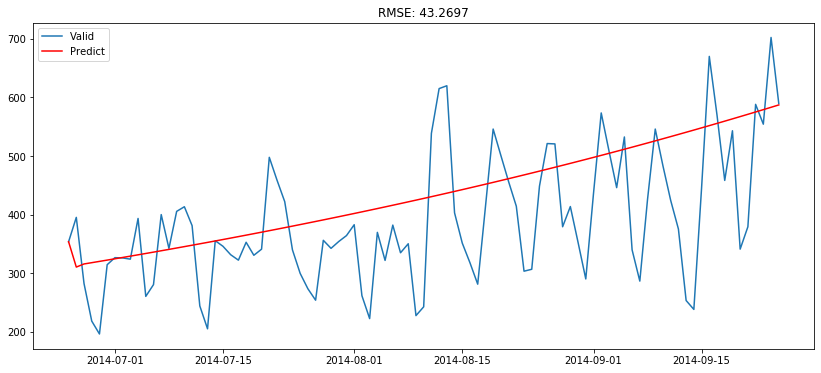

In [65]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25") 
MA_predict=MA_predict.cumsum().shift().fillna(0) 
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
MA_predict1=MA_predict1.add(MA_predict,fill_value=0) 
MA_predict = np.exp(MA_predict1)

plt.figure(figsize=(14,6)) 
plt.plot(valid['Count'], label = "Valid") 
plt.plot(MA_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0])) 
plt.show()

Now let’s combine these two models.
### Combined model

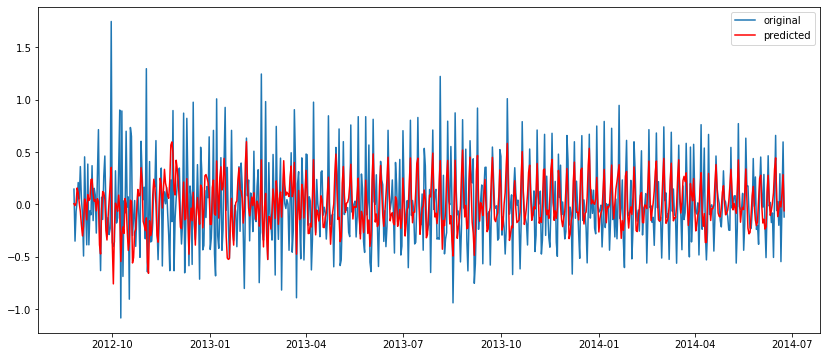

In [66]:
model = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  

plt.figure(figsize=(14,6)) 
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show()

Let’s define a function which can be used to change the scale of the model to the original scale.

In [67]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()


def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
 
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

Let’s predict the values for validation set.

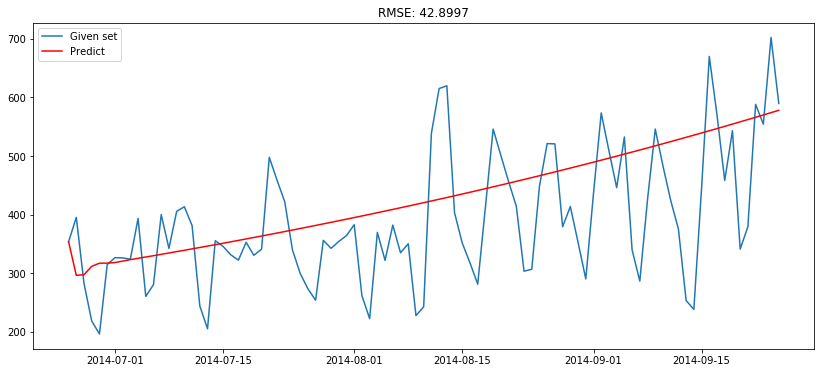

In [68]:
plt.figure(figsize=(14,6)) 

ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25", end="2014-09-25")

check_prediction_diff(ARIMA_predict_diff, valid)

### 7) SARIMAX model on daily time series
SARIMAX model takes into account the seasonality of the time series. So we will build a SARIMAX model on the time series.

/home/ambir/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


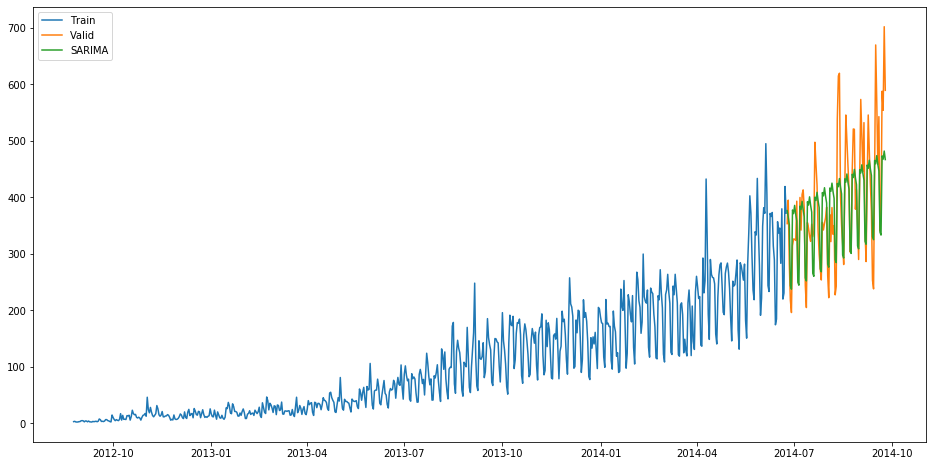

In [69]:
import statsmodels.api as sm

y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

-    Order in the above model represents the order of the autoregressive model(number of time lags), the degree of differencing(number of times the data have had past values subtracted) and the order of moving average model.
-    Seasonal order represents the order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.
-    In our case the periodicity is 7 since it is daily time series and will repeat after every 7 days.

In [70]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA)) 
print(rms)

69.70161090767438


Now we will forecast the time series for Test data which starts from 2014-9-26 and ends at 2015-4-26.

In [71]:
predict=fit1.predict(start="2014-9-26", end="2015-4-26", dynamic=True)

/home/ambir/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


In [72]:
test['prediction']=predict

# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left')
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1) 

In [73]:
# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='Hour', how='left') 

# Converting the ratio to the original scale 
prediction['Count']=prediction['prediction']*prediction['ratio']*24

In [74]:
prediction['ID']=prediction['ID_y'] 
submission=prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1) 

# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('SARIMAX.csv')